In [4]:
import os

if "notebooks" in os.getcwd():
    %cd ..
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from src.utils.defines import INTERIM_DATA_DIR, AUGMENTED_DATA_DIR, PROCESSED_DATA_DIR
import matplotlib.patches as mpatches

In [23]:
train_df = pd.read_csv(os.path.join(INTERIM_DATA_DIR, "train.csv"))
val_df = pd.read_csv(os.path.join(INTERIM_DATA_DIR, "val.csv"))

train_aug_insertion = pd.read_csv(os.path.join(AUGMENTED_DATA_DIR, "train_augmented_random_insertion_emb.csv"))
train_aug_synonym = pd.read_csv(os.path.join(AUGMENTED_DATA_DIR, "train_augmented_synonym_replacement_emb.csv"))

train_aug_insertion_sf = pd.read_csv(os.path.join(AUGMENTED_DATA_DIR, "sf_train_augmented_random_insertion_emb.csv"))
train_aug_synonym_sf = pd.read_csv(os.path.join(AUGMENTED_DATA_DIR, "sf_train_augmented_synonym_replacement_emb.csv"))

train_rand_swap = pd.read_csv(os.path.join(AUGMENTED_DATA_DIR, "train_augmented_random_swap.csv"))
train_self_training = pd.read_csv(os.path.join(AUGMENTED_DATA_DIR, "task_b_GAB_aug.csv"))
train_self_training_reddit = pd.read_csv(os.path.join(AUGMENTED_DATA_DIR, "task_b_reddit_aug.csv"))

train_self_training_GAB_FULL = pd.read_csv(os.path.join(AUGMENTED_DATA_DIR, "task_a_GAB_aug_99conf_FULL.csv"))
train_self_training_reddit_FULL = pd.read_csv(os.path.join(AUGMENTED_DATA_DIR, "task_a_reddit_aug_99conf_FULL.csv"))
# Explore task a
train_task_a = train_df.drop(['rewire_id', 'target_b', 'target_c'], axis=1)

In [8]:
task_a_unlabeled = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, "probs_task_a_FULL_distil_roberta.csv"))

unlabeled_reddit0 = pd.read_csv(os.path.join(PROCESSED_DATA_DIR,"df_0reddit.csv"))
unlabeled_reddit1 = pd.read_csv(os.path.join(PROCESSED_DATA_DIR,"df_1reddit.csv"))
unlabeled_reddit2 = pd.read_csv(os.path.join(PROCESSED_DATA_DIR,"df_2reddit.csv"))
# unlabeled_reddit3 = pd.read_csv(os.path.join("./data/", "df_3reddit.csv"))
# unlabeled_reddit4 = pd.read_csv(os.path.join("./data/", "df_4reddit.csv"))

unlabeled_GAB0 = pd.read_csv(os.path.join(PROCESSED_DATA_DIR,"df_0GAB.csv"))
unlabeled_GAB1 = pd.read_csv(os.path.join(PROCESSED_DATA_DIR,"df_1GAB.csv"))
unlabeled_GAB2 = pd.read_csv(os.path.join(PROCESSED_DATA_DIR,"df_2GAB.csv"))
unlabeled_GAB3 = pd.read_csv(os.path.join(PROCESSED_DATA_DIR,"df_3GAB.csv"))
unlabeled_GAB4 = pd.read_csv(os.path.join(PROCESSED_DATA_DIR,"df_4GAB.csv"))

unlabeled_data = pd.concat([
    unlabeled_GAB0,
    unlabeled_GAB1,
    unlabeled_GAB2,
    unlabeled_GAB3,
    unlabeled_GAB4,
    unlabeled_reddit0,
    unlabeled_reddit1,
    unlabeled_reddit2
    ])

In [9]:
merged_df = task_a_unlabeled.merge(unlabeled_data, left_index=True, right_index=True, how='inner')

In [11]:
# Set a confidence threshold for pseudo-labeling
confidence_threshold = 0.95
test = np.array(task_a_unlabeled)

# Get the most confident predictions and their indices
most_confident_indices = np.where(test.max(axis=1) > confidence_threshold)[0]
most_confident_preds = pd.DataFrame(test.argmax(axis=1)[most_confident_indices])

most_confident_preds.columns = ['target_a']
most_confident_preds

,target_a
0,0
1,0
2,0
3,0
4,0
...,...
1423204,0
1423205,0
1423206,0
1423207,0


In [15]:
text_task_a = unlabeled_data.iloc[most_confident_indices].reset_index(drop=True)

In [22]:
final_task_a = pd.concat([text_task_a, most_confident_preds],axis=1)
final_task_a

,text,key,target_a
0,JUST SAYING.... YOU LOSE BIATCHES,0GAB,0
1,HOW WOULD I DESCRIBE BERKELEY RIOTS? 1) Charmi...,1GAB,0
2,Or maybe a little south of Herring Run. More l...,2GAB,0
3,That's funny...but,3GAB,0
4,Unbelievable! It Was (((Rosenstein))) Who Hid ...,4GAB,0
...,...,...,...
1423204,get your ducks all in a row can you elaborate?...,599993reddit,0
1423205,only makes sense that they’re so close to water,599994reddit,0
1423206,"This is the moron of the ""no bad tactics only ...",599995reddit,0
1423207,"If you’re passing by, then don’t talk to them.",599996reddit,0


In [20]:
dummy_values = np.random.rand(len(final_task_a))
df = final_task_a.copy()
df = df.assign(target_b=pd.Series(dummy_values))
df = df.assign(target_c=pd.Series(dummy_values))
df = df.assign(rewire_id=pd.Series(dummy_values))
df = df.reindex(columns=['rewire_id', 'text', 'target_a', 'target_b', 'target_c'])
df.to_csv("task_a_reddit_aug_distilrobert.csv")

In [26]:
train_task_a['target_a'].value_counts()

0    10602
1     3398
Name: target_a, dtype: int64

In [27]:
aug_task_a_sexist['target_a'].value_counts()

1    16483
0    10602
Name: target_a, dtype: int64

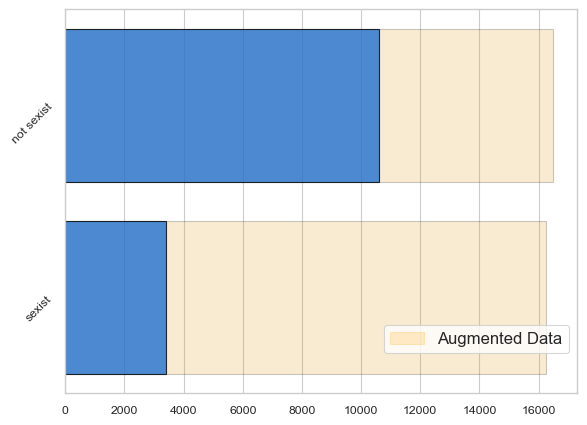

In [77]:
df_a_sexist = df.loc[df['target_a'] == 1]
orig_len_df_sexist = len(df_a_sexist)

df_a_not_sexist = df.loc[df['target_a'] == 0]
orig_len_df_not_sexist = len(df_a_not_sexist)

aug_task_a_sexist = pd.concat([train_task_a,
                               df_a_sexist.sample(int(orig_len_df_sexist * 1)),
                               df_a_not_sexist.sample(int(orig_len_df_not_sexist * 0.004))
                        ])

# Count the number of occurrences of each class label
counts = train_task_a['target_a'].value_counts()
counts1 = aug_task_a_sexist['target_a'].value_counts()

# Create a horizontal bar plot using Seaborn
palette = sns.color_palette("muted")
sns.set_context("paper")
ax = sns.barplot(x=counts1.values, y=counts1.index, order=counts1.index, color='orange', orient='h',
            edgecolor="black", alpha=0.2)

cerulean_blue = (0.02, 0.43, 0.93)
ax = sns.barplot(x=counts.values, y=counts.index, color=cerulean_blue, orient='h',
            edgecolor="black", alpha=0.8)


# Set y-axis tick labels
ax.set_yticklabels(['not sexist', 'sexist'])
plt.yticks(rotation=45)
# labels = ['1 not sexist', '2 sexist']
# labels_axis = ['1', '2']
# plt.yticks([0, 1], labels_axis)

proxy_artists = [mpatches.Patch(color='orange', label='Augmented Data', alpha=0.2)]
# # Create the legend
plt.legend(handles=proxy_artists, loc='upper right', fontsize=12, bbox_to_anchor=(1, 0.2))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
# plt.savefig('TaskA-ClassProportion-FINALE_distilroberta.png', dpi=500)

In [187]:
aug_task_a_sexist = aug_task_a_sexist[['rewire_id', 'text', 'target_a', 'target_b', 'target_c']]
# aug_task_a_sexist.to_csv(Path(AUGMENTED_DATA_DIR, f"task_a_balanced_distilroberta.csv"), index=False)

In [41]:
# take only sexist data
sexist_new = aug_task_a_sexist.loc[aug_task_a_sexist['target_a'] == 1]
sexist_new.to_csv(f'task_b_distilroberta.csv', index=False)

In [44]:
self_training_b = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, "probs_task_b_FULL_distil_roberta.csv"))
self_training_c = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, "probs_task_c_FULL_distil_roberta.csv"))
unlabeled_task_text = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, "unlabeled_data_FULL_distil_roberta.csv"))

In [142]:
confidence_threshold = 0.75
test = np.array(self_training_b)

# Get the most confident predictions and their indices
most_confident_indices = np.where(test.max(axis=1) > confidence_threshold)[0]
most_confident_preds = pd.DataFrame(test.argmax(axis=1)[most_confident_indices])
most_confident_preds.columns = ['target_b']

text_task_b = unlabeled_task_text.iloc[most_confident_indices].reset_index(drop=True)

final_task_b = pd.concat([text_task_b, most_confident_preds],axis=1)
final_task_b

,0,target_b
0,I did. You have to have the bravery to escalat...,0
1,"Not going to lie, the brutal honesty of this r...",0
2,"Please.... take my wife, rape my daughter!! Bu...",0
3,Pink is very feminine so I accept this bikini ...,2
4,The she-god mentality of women is going down t...,1
...,...,...
4699,Dumb bitch,2
4700,"Cry some more, Nazi pussy. Welcome to #Gab",2
4701,This stupid geriatric old cunt couldn't avenge...,1
4702,Everyone in the West should ask themselves 3 q...,2


In [143]:
unique_values, counts = np.unique(most_confident_preds, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 273
1: 2131
2: 2232
3: 68


threats, plans to harm and incitement: 310
derogation: 1590
animosity: 1165
prejudiced discussions: 333
total sexist task b: 3398
augmented dataset b count: 5025, aug ratio: 1.4788110653325486


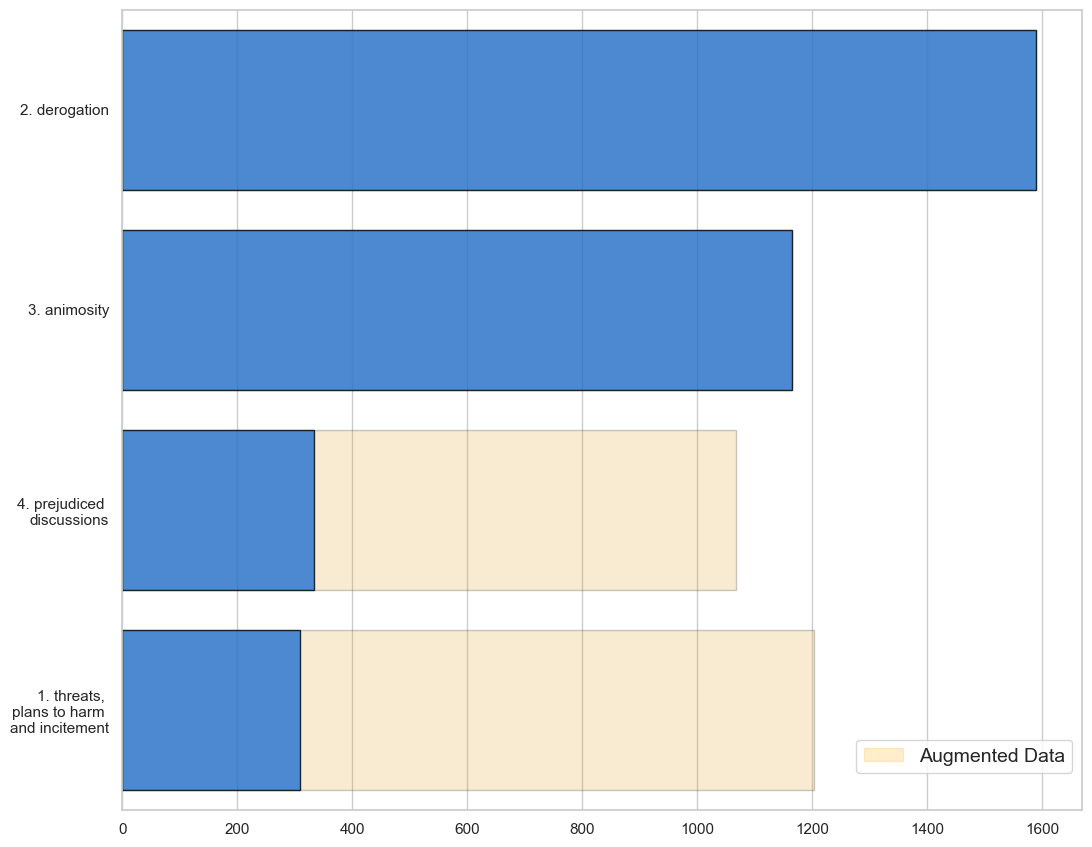

In [182]:
# Explore task b
# train_task_b = train_df.drop(['rewire_id', 'target_a', 'target_c'], axis=1)
train_task_b = train_df.copy()
train_task_b = train_task_b.loc[train_task_b['target_b'] != -1]

b1 = train_task_b.loc[train_task_b['target_b'] == 0]
b1_aug_syn = train_aug_synonym.loc[train_aug_synonym['target_b'] == 0]
b1_aug_insertion = train_aug_insertion.loc[train_aug_insertion['target_b'] == 0]
b1_aug_swap = train_rand_swap.loc[train_rand_swap['target_b'] == 0]
b1_sf = final_task_b.loc[final_task_b['target_b'] == 0]
print(f"threats, plans to harm and incitement: {len(b1)}")

b2 = train_task_b.loc[train_task_b['target_b'] == 1]
b2_aug_syn = train_aug_synonym.loc[train_aug_synonym['target_b'] == 1]
b2_aug_insertion = train_aug_insertion.loc[train_aug_insertion['target_b'] == 1]
b2_sf = final_task_b.loc[final_task_b['target_b'] == 1]
print(f"derogation: {len(b2)}")

b3 = train_task_b.loc[train_task_b['target_b'] == 2]
b3_aug_syn = train_aug_synonym.loc[train_aug_synonym['target_b'] == 2]
b3_aug_insertion = train_aug_insertion.loc[train_aug_insertion['target_b'] == 2]
b3_sf = final_task_b.loc[final_task_b['target_b'] == 2]
print(f"animosity: {len(b3)}")

b4 = train_task_b.loc[train_task_b['target_b'] == 3]
b4_aug_syn = train_aug_synonym.loc[train_aug_synonym['target_b'] == 3]
b4_aug_insertion = train_aug_insertion.loc[train_aug_insertion['target_b'] == 3]
b4_aug_swap = train_rand_swap.loc[train_rand_swap['target_b'] == 3]
b4_sf = final_task_b.loc[final_task_b['target_b'] == 3]
print(f"prejudiced discussions: {len(b4)}")

print(f"total sexist task b: {len(pd.concat([b1, b2, b3, b4]))}")

aug_task_b = pd.concat([train_task_b,
                        b1_aug_insertion.sample(int(len(b1) * 1)),
                        b1_aug_syn.sample(int(len(b1) * 1)),
                        b1_aug_swap.sample(int(len(b1) * 0)),

                        b2_aug_insertion.sample(int(len(b2) * 0)),
                        b2_aug_syn.sample(int(len(b2) * 0)),

                        b3_aug_insertion.sample(int(len(b3) *0)),
                        b3_aug_syn.sample(int(len(b3) * 0)),

                        b4_aug_syn.sample(int(len(b4) * 1)),
                        b4_aug_insertion.sample(int(len(b4) * 1)),

                        b1_sf.sample(int(len(b1_sf) * 1)),
                        b2_sf.sample(int(len(b2_sf) * 0)),
                        b3_sf.sample(int(len(b3_sf) * 0)),
                        b4_sf.sample(int(len(b4_sf) * 1))])

print(f"augmented dataset b count: {len(aug_task_b)}, aug ratio: {len(aug_task_b)/len(train_task_b)}")

# aug_task_b.to_csv(Path(AUGMENTED_DATA_DIR, f"augmented_task_b.csv"), index=False)

sns.set_context("paper")
plt.figure(figsize=(12, 10))
sns.set_theme(style="whitegrid")

# plt.ylabel("Counts", size=14)
# plt.xlabel("Target Label", size=14)
# plt.title("Task B - Class Proportion", size=18)

# Count the number of occurrences of each class label
counts = train_task_b['target_b'].value_counts()
counts1 = aug_task_b['target_b'].value_counts()

# Create a bar plot using Seaborn
palette = sns.color_palette("muted")

sns.barplot(x=counts1.values, y=counts1.index, color='orange', order=counts.index, edgecolor="black", alpha=0.2, orient='h')

cerulean_blue = (0.02, 0.43, 0.93)
ax = sns.barplot(x=counts.values, y=counts.index, order=counts.index, color=cerulean_blue, orient='h',
            edgecolor="black", alpha=0.8)

ax.set_yticklabels(['2. derogation', '3. animosity', '4. prejudiced \ndiscussions', '1. threats, \nplans to harm \nand '
                                                                                    'incitement'])
plt.yticks(rotation=0)

# labels = ['1 derogation', '2 animosity', '3 prejudiced discussions', '4 threats, plans to harm and incitement']
# labels_axis = ['1', '2', '3', '4']
# plt.xticks([0, 1, 2, 3], labels_axis)

# Create proxy artists for the legend
# proxy_artists = []
# for i, (label, color) in enumerate(zip(labels, palette)):
#     proxy_artists.append(mpatches.Patch(color=color, label=label, edgecolor='black', alpha=1))
#     if i == 3:
#         # Add a separate bar for augmented data
#         proxy_artists.append(mpatches.Patch(color='orange', label="augmented data", edgecolor='black', alpha=0.1))
#
proxy_artists = [mpatches.Patch(color='orange', label='Augmented Data', alpha=0.2)]
# # Create the legend
plt.legend(handles=proxy_artists, loc='upper right', fontsize=14, bbox_to_anchor=(1, 0.1))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
# plt.savefig('TaskB-ClassProportion_aug_FINALE_distilroberta.png', dpi=500)

In [183]:
aug_task_file_b = pd.concat([train_task_b,
                        b1_aug_insertion.sample(int(len(b1) * 1)),
                        b1_aug_syn.sample(int(len(b1) * 1)),
                        b4_aug_syn.sample(int(len(b4) * 1)),
                        b4_aug_insertion.sample(int(len(b4) * 1)),
                        b1_sf.rename(columns={'0': 'text'}).sample(int(len(b1_sf) * 1)),
                        b4_sf.rename(columns={'0': 'text'}).sample(int(len(b4_sf) * 1))])

# aug_task_file_b.to_csv("task_b_balanced_distilroberta.csv", index=False)

In [181]:
aug_task_file_b

,rewire_id,text,target_a,target_b,target_c
4,sexism2022_english-7228,[USER] Leg day is easy. Hot girls who wear min...,1.0,2,7.0
6,sexism2022_english-872,I get a new pussy every other week or whenever...,1.0,1,4.0
11,sexism2022_english-14992,O come on there's no way any men are attracted...,1.0,1,4.0
21,sexism2022_english-7260,Former BBC journalist Thuto Mali says that uni...,1.0,3,10.0
25,sexism2022_english-7022,I did. You have to have the bravery to escalat...,1.0,0,1.0
...,...,...,...,...,...
1039,NaN,Fifteen months in jail and five years probatio...,NaN,3,NaN
442,NaN,"*Her sentence, of 16 months to four years, mea...",NaN,3,NaN
1045,NaN,If she's not tied up with a gag and obviously ...,NaN,3,NaN
202,NaN,you want men to do better? then remove affirma...,NaN,3,NaN


In [ ]:
#################################################################################################################
confidence_threshold = 0.75
test = np.array(self_training_c)

# Get the most confident predictions and their indices
most_confident_indices = np.where(test.max(axis=1) > confidence_threshold)[0]
most_confident_preds = pd.DataFrame(test.argmax(axis=1)[most_confident_indices])
most_confident_preds.columns = ['target_c']

text_task_c = unlabeled_task_text.iloc[most_confident_indices].reset_index(drop=True)

final_task_c = pd.concat([text_task_c, most_confident_preds],axis=1)
final_task_c

In [195]:
most_confident_preds

,target_c
0,0
1,0
2,0
3,2
4,1
...,...
4699,2
4700,2
4701,1
4702,2


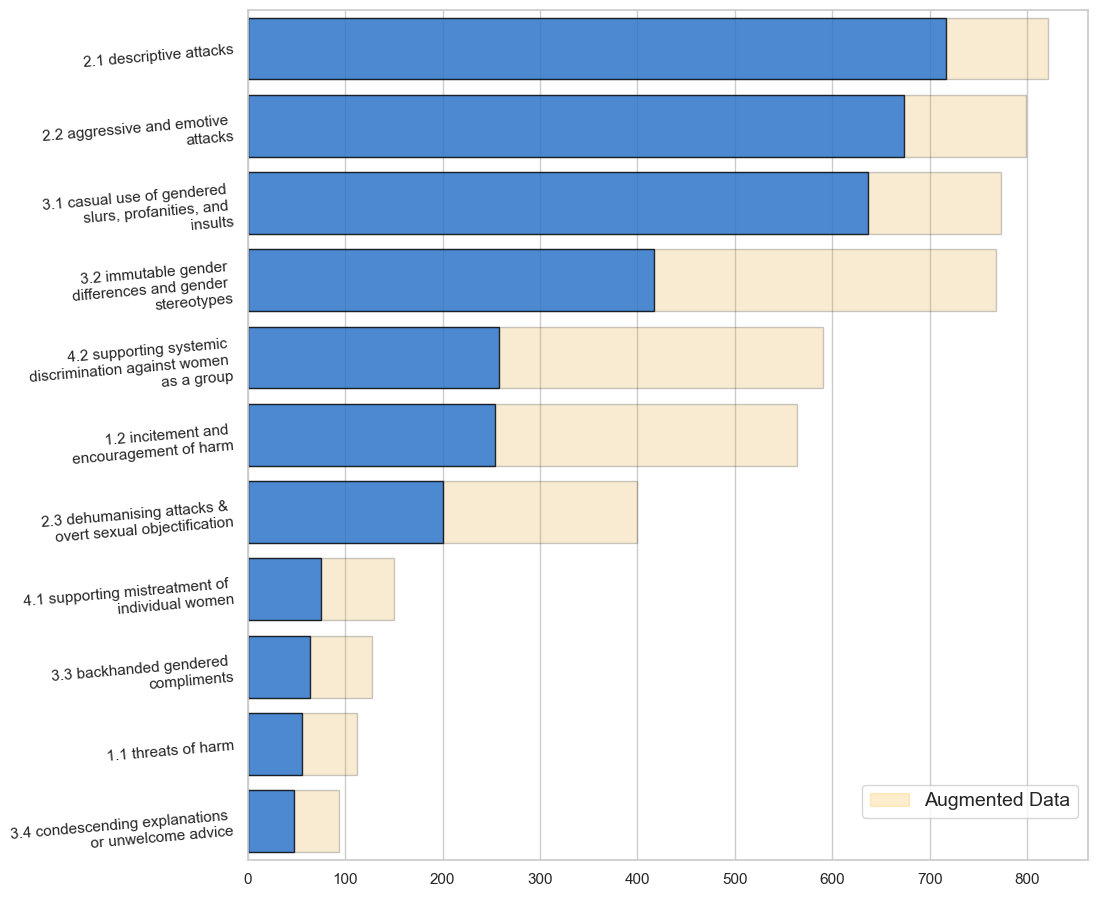

In [172]:
train_task_c = train_df.copy()
train_task_c = train_task_c.loc[train_task_c['target_c'] != -1]
final_task_c_wo3_5 = final_task_c.loc[(final_task_c['target_c'] != 5) & (final_task_c['target_c'] != 3)]

final_task_c_w5 = final_task_c.loc[final_task_c['target_c'] == 5]
orig_5 = len(final_task_c_w5['target_c'])

final_task_c_w3 = final_task_c.loc[final_task_c['target_c'] == 3]
orig_3 = len(final_task_c_w3['target_c'])

orig_0 = len(train_aug_insertion.loc[train_aug_insertion['target_c'] == 0])
orig_1 = len(train_aug_insertion.loc[train_aug_insertion['target_c'] == 1])
orig_2 = len(train_aug_insertion.loc[train_aug_insertion['target_c'] == 2])
orig_4 = len(train_aug_insertion.loc[train_aug_insertion['target_c'] == 4])
orig_6 = len(train_aug_insertion.loc[train_aug_insertion['target_c'] == 6])
orig_7 = len(train_aug_insertion.loc[train_aug_insertion['target_c'] == 7])
orig_8 = len(train_aug_insertion.loc[train_aug_insertion['target_c'] == 8])
orig_9 = len(train_aug_insertion.loc[train_aug_insertion['target_c'] == 9])
orig_10 =len(train_aug_insertion.loc[train_aug_insertion['target_c'] == 10])

train_task_c['target_c'].value_counts()
#%
aug_task_c = pd.concat([train_task_c,
                        final_task_c_wo3_5.rename(columns={'0': 'text'}),
                        final_task_c_w5.rename(columns={'0': 'text'}).sample(int(orig_5 * 0.05)),
                        final_task_c_w3.rename(columns={'0': 'text'}).sample(int(orig_3 * 0.2)),
                        train_aug_insertion.loc[train_aug_insertion['target_c'] == 0].sample(int(orig_0 * 1)),
                        train_aug_insertion.loc[train_aug_insertion['target_c'] == 1].sample(int(orig_1 * 1)),
                        train_aug_insertion.loc[train_aug_insertion['target_c'] == 2].sample(int(orig_2 * 0)),
                        train_aug_insertion.loc[train_aug_insertion['target_c'] == 4].sample(int(orig_4 * 1)),
                        train_aug_insertion.loc[train_aug_insertion['target_c'] == 6].sample(int(orig_6 * 0.8)),
                        train_aug_insertion.loc[train_aug_insertion['target_c'] == 7].sample(int(orig_7 * 1)),
                        train_aug_insertion.loc[train_aug_insertion['target_c'] == 8].sample(int(orig_8 * 1)),
                        train_aug_insertion.loc[train_aug_insertion['target_c'] == 9].sample(int(orig_9 * 1)),
                        train_aug_insertion.loc[train_aug_insertion['target_c'] == 10].sample(int(orig_10 * 1))])

# sns.set_context("paper")
plt.figure(figsize=(12, 10))
sns.set_theme(style="whitegrid")


# Count the number of occurrences of each class label
counts = train_task_c['target_c'].value_counts()
counts1 = aug_task_c['target_c'].value_counts()

# Create a bar plot using Seaborn
palette = sns.color_palette("muted")

sns.barplot(x=counts1.values, y=counts1.index, color='orange', order=counts.index, edgecolor="black", alpha=0.2, orient='h')

cerulean_blue = (0.02, 0.43, 0.93)
ax = sns.barplot(x=counts.values, y=counts.index, order=counts.index, color=cerulean_blue, orient='h',
            edgecolor="black", alpha=0.8)

ax.set_yticklabels(['2.1 descriptive attacks',
                    '2.2 aggressive and emotive \nattacks',
                    '3.1 casual use of gendered \nslurs, profanities, and \ninsults',
                    '3.2 immutable gender \ndifferences and gender \nstereotypes',
                    '4.2 supporting systemic \ndiscrimination against women \nas a group',
                    '1.2 incitement and \nencouragement of harm',
                    '2.3 dehumanising attacks & \novert sexual objectification',
                    '4.1 supporting mistreatment of \nindividual women',
                    '3.3 backhanded gendered \ncompliments',
                    '1.1 threats of harm',
                    '3.4 condescending explanations \nor unwelcome advice',
                    ])
plt.yticks(rotation=5)

# labels = ['1 derogation', '2 animosity', '3 prejudiced discussions', '4 threats, plans to harm and incitement']
# labels_axis = ['1', '2', '3', '4']
# plt.xticks([0, 1, 2, 3], labels_axis)

# Create proxy artists for the legend
# proxy_artists = []
# for i, (label, color) in enumerate(zip(labels, palette)):
#     proxy_artists.append(mpatches.Patch(color=color, label=label, edgecolor='black', alpha=1))
#     if i == 3:
#         # Add a separate bar for augmented data
#         proxy_artists.append(mpatches.Patch(color='orange', label="augmented data", edgecolor='black', alpha=0.1))
#
proxy_artists = [mpatches.Patch(color='orange', label='Augmented Data', alpha=0.2)]
# # Create the legend
plt.legend(handles=proxy_artists, loc='upper right', fontsize=14, bbox_to_anchor=(1, 0.1))
plt.subplots_adjust(left=0.2, right=0.9, bottom=0.05, top=0.9)
# plt.savefig('TaskC-ClassProportion_aug_FINALE_distilroberta.png', dpi=500)

In [175]:
aug_task_file_c = pd.concat([train_task_c,
                        final_task_c_wo3_5.rename(columns={'0': 'text'}),
                        final_task_c_w5.rename(columns={'0': 'text'}).sample(int(orig_5 * 0.05)),
                        final_task_c_w3.rename(columns={'0': 'text'}).sample(int(orig_3 * 0.2)),
                        train_aug_insertion.loc[train_aug_insertion['target_c'] == 0].sample(int(orig_0 * 1)),
                        train_aug_insertion.loc[train_aug_insertion['target_c'] == 1].sample(int(orig_1 * 1)),
                        train_aug_insertion.loc[train_aug_insertion['target_c'] == 2].sample(int(orig_2 * 0)),
                        train_aug_insertion.loc[train_aug_insertion['target_c'] == 4].sample(int(orig_4 * 1)),
                        train_aug_insertion.loc[train_aug_insertion['target_c'] == 6].sample(int(orig_6 * 0.8)),
                        train_aug_insertion.loc[train_aug_insertion['target_c'] == 7].sample(int(orig_7 * 1)),
                        train_aug_insertion.loc[train_aug_insertion['target_c'] == 8].sample(int(orig_8 * 1)),
                        train_aug_insertion.loc[train_aug_insertion['target_c'] == 9].sample(int(orig_9 * 1)),
                        train_aug_insertion.loc[train_aug_insertion['target_c'] == 10].sample(int(orig_10 * 1))])

aug_task_file_c_suffled = aug_task_file_c.sample(frac=1, replace=False)
# aug_task_file_c_suffled.to_csv("task_c_balanced_distilroberta.csv", index=False)

In [174]:
final_task_c_w3.rename(columns={'0': 'text'}).sample(int(orig_3 * 0.2))

,text,target_c
2491,"You LTRed a cheating whore. But now it's over,...",3
1531,Id call for an end of her efforts. She is a je...,3
3425,Couldn't care less what that slag says....she ...,3
3235,this slitoral bitch needs to get a visit form ...,3
2023,She's a botoxed slut whose long past her sell ...,3
...,...,...
1807,Bruh the entire time I watched the video I was...,3
2933,No matter how many nose jobs your goilfriend h...,3
483,Looks like the feminist overlords sent their l...,3
1019,Mother of eight looking for the welfare chooo ...,3
